# Installation of Pytorch
Pytorch binary can be installed by pip, or complied following instructions in https://github.com/pytorch/pytorch#from-source.

Here we will use pip.

In [36]:
try:
    import torch
except:
    !pip install http://download.pytorch.org/whl/cu80/torch-0.4.0.post4-cp36-cp36m-linux_x86_64.whl
    import torch

# Introducing Pytorch
Pytoch is composed of three parts: Tensors, Autograd and Module.

For more detailed tutorial, refer to http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html.

## Tensors
They are like numpy arrays, you can do basic operations on them, like:

In [37]:
import numpy as np
import torch

a = torch.tensor([1,2,3], dtype = torch.float32)
b = torch.tensor([3,4,5]).to(torch.float32) # you can clarify tensors' dtype at definition or use to method to convert. 

c = a+b # add.

a = torch.ones(4,4)
b = torch.ones(4)

c = torch.mv(a,b) # matrix multiply vector.

a = torch.randn(4,4)
b = torch.randn(4,3)

c = torch.mm(a,b) # matrix multiply matrix.

# indexing Tensor is the same as indexing numpy array.

c[:,0]

a_np = a.numpy() # convert tensor to numpy array.

d = torch.from_numpy(a_np) # convert numpy array to tensor.

## Autograd
Also, after pytorch 0.4, tensors can be used as a node in computation graph(or called Variable in 0.3 and before). They can be used to calculate gradients, like:

In [38]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
out = z.mean()
print(out) # the result of above computation.
print(out.grad_fn) # print the former point of out in computation graph.
out.backward() # do backward of this computation graph.
print(x.grad) # the gradient of original X.

print(x.detach()) # detach() gives a copy of tensor called on and this copy doesn't need gradients.
print(out.detach().numpy()) # note that after used in computation graph you have to detach to call numpy().

tensor(27., grad_fn=<MeanBackward1>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[1., 1.],
        [1., 1.]])
27.0


## Module
To define a neural network, we need Module. Module is the base class for all neural network modules.

The following code define a neural network same as the neural network wrote using numpy in BP tutorial

In [39]:
import torch.nn as nn

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.fc(x)
        x = self.softmax(x)
        return x

net = Net()
print(net)

Net(
  (fc): Linear(in_features=784, out_features=10, bias=True)
  (softmax): Softmax()
)


Neural Networks can also be defined by ModuleList. ModuleList is a list-like class holds submodules in a list.

And for a large neural network, you may want to compress it into a single Module class, so you can just call .forward() instead of calling each layer's .forward() one by one. In that situation, we can use nn.Sequential.

(For difference between nn.Sequential and nn.ModuleList, see https://discuss.pytorch.org/t/when-should-i-use-nn-modulelist-and-when-should-i-use-nn-sequential/5463)

For more detailed APIs, refer to http://pytorch.org/docs/master/nn.html?highlight=modulelist#torch.nn.ModuleList and http://pytorch.org/docs/master/nn.html?highlight=sequential#torch.nn.Sequential

The example following defines the same network as above.

In [40]:
class Net(nn.Module):
  
    def __init__(self):
        super(Net, self).__init__()
        self.nn_list = nn.ModuleList()
        self.nn_list.append(torch.nn.Sequential(
          nn.Linear(784, 10),nn.Softmax())) # create a list of Module instants which has only one forward and backward to call.

    def forward(self, x):
      x = self.nn_list[0](x) # [0] here index the fist (and also the only) Module instant.
      return x
    
net = Net()
print(net)

Net(
  (nn_list): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=10, bias=True)
      (1): Softmax()
    )
  )
)


# NICE Network

Arxiv link: https://arxiv.org/abs/1410.8516

We are going to do unsupervised learning on a denisty estimation problem. So our training data has no labels, and we are going to fit samples' probability distribution.


## Loading data
First, let's load training data.

The loaded data is sampled from a 2d ring. We are going to use NICE network to fit this distribution, so that when we feed NICE with gaussian samples it will output samples in this 2d ring.

--2019-03-31 12:02:58--  https://pastebin.com/raw/JWgv53pd
Resolving pastebin.com (pastebin.com)... 2606:4700:10::6814:d015, 2606:4700:10::6814:d115, 104.20.208.21, ...
Connecting to pastebin.com (pastebin.com)|2606:4700:10::6814:d015|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘train.dat’

train.dat               [ <=>                ] 180.85K  1.14MB/s    in 0.2s    

2019-03-31 12:02:59 (1.14 MB/s) - ‘train.dat’ saved [185188]



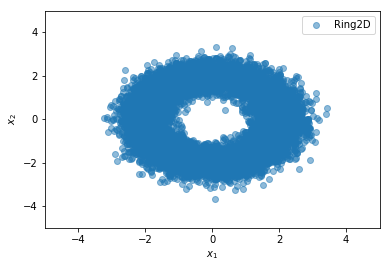

In [41]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

!wget https://pastebin.com/raw/JWgv53pd -O train.dat # download training data using wget.
  
xy = np.loadtxt('./train.dat', dtype=np.float32) # load data file.
x_data = torch.from_numpy(xy).to(torch.float32)

plt.figure() # plot training date.
plt.scatter(xy[:,0], xy[:,1], alpha=0.5, label='Ring2D')
plt.legend()

plt.xlim([-5, 5]) # limit x and y axes between [-5,5] for better viewing.
plt.ylim([-5, 5])

plt.xlabel('$x_1$') # label axes
plt.ylabel('$x_2$')

plt.show()

## Define a NICE Network
At each layer, input $y$ is divided into $y_0$ and $y_1$. And the transformation is as below:


\begin{equation}
\left\{
\begin{array}\\
y_0' = y_0+t(y_1) \\
y_1' = y_1
\end{array}
\right.
\end{equation}

Then, at each layer, the role of $y_0$ and $y_1$ is switched, so that every elements in input $y$ is altered.
This transformation has a lower triangle matrix Jacobian, with its $\ln(determinant)$ equals 0.
\begin{equation}
\ln
\left|
\begin{array}\\
1&0\\
\frac{\partial{t}}{\partial{y_1}}&1
\end{array}
\right|
= 0
\end{equation}
This ensure at each layer,
\begin{equation}
\ln p(\boldsymbol{y'}) =  \ln p (\boldsymbol{y})
\end{equation}
Then, we can project $\boldsymbol{y}$ into $\boldsymbol{z}$ in latent space, and 
\begin{equation}
\ln p(\boldsymbol{y}) =  \ln p (\boldsymbol{z})
\end{equation}

In [42]:
class NICE(torch.nn.Module):
    '''
    A Pytorch implement of NICE Network.
    
    Args:
        num_vars(int): length of inputs.
        num_layers(int): number of NICE layers.
        hidden_t(int): number of hidden units of in each t layer.
       
    Attributes:
        num_vars(int): length of inputs.
        num_layers(int): number of NICE layers.
        translation(nn.ModuleList): list of translation layers.
    '''
    def __init__(self, num_vars, num_layers=2,hidden_t=10):
        super(NICE, self).__init__()
        self.num_vars = num_vars
        self.num_layers = num_layers

        self.translation = torch.nn.ModuleList()
        for i in range(self.num_layers):
            self.translation.append(
                 torch.nn.Sequential(
                 torch.nn.Linear(num_vars//2, hidden_t),
                 torch.nn.ReLU(),
                 torch.nn.Linear(hidden_t, num_vars//2)
                 ))

    def forward(self, z):
        '''
        Generate target distribution from z sampled from gaussian distribution.
        '''
        y0 = z[:,:self.num_vars//2]
        y1 = z[:,self.num_vars//2:]
        
        for i in range(self.num_layers):
            if (i%2==0):
                y1 = y1 + self.translation[i](y0)
            else:
                y0 = y0 +  self.translation[i](y1)
        return torch.cat((y0, y1), 1)

    def inverse(self, x):
        '''
        Inference gaussian distribution from x sampled from target distribution.
        '''
        y0 = x[:,:self.num_vars//2]
        y1 = x[:,self.num_vars//2:]
        for i in reversed(range(self.num_layers)):
            if (i%2==1):
                y0 = y0 - self.translation[i](y1)
            else:
                y1 = y1 - self.translation[i](y0)
        return torch.cat((y0, y1), 1)

    def logp(self, x):
        '''
        Calculate x's log(probability).
        '''
        z = self.inverse(x)
        return -0.5*(z**2).sum(dim=1)

## Bijective Check

Because NICE network can generate samples of a target distribution from simple distribution, and also can inference simple distribution from target ditribution. So after implementing  NICE, we should check it's reversibility.

In [43]:
num_vars = 4 
model = NICE(num_vars) 
z = torch.randn(1000,num_vars)

x = model.forward(z) # generate a new dataset.
z_infer = model.inverse(x) # inference back to the original dataset.

from numpy.testing import assert_array_almost_equal
assert_array_almost_equal(z_infer.detach().numpy(),z.detach().numpy()) # test if they are the same.

## Training Network

Next, we are going to fit a 2d ring using a gaussian distribution.

OK, let's define a NICE instance and an optimizer.

In [44]:
torch.manual_seed(42)

num_epochs = 800 # define parameters of NICE network.
num_layers = 4
hidden_t = 10
num_samples = 2000
num_vars = x_data.shape[-1]

model = NICE(num_vars, num_layers,hidden_t) # define NICE instance and optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

Start training.

epoch: 0 loss: 2.697908878326416
epoch: 50 loss: 2.2369253635406494
epoch: 100 loss: 2.2355129718780518
epoch: 150 loss: 2.2338204383850098
epoch: 200 loss: 2.2313356399536133
epoch: 250 loss: 2.2262051105499268
epoch: 300 loss: 2.174683094024658
epoch: 350 loss: 1.8499902486801147
epoch: 400 loss: 1.616895318031311
epoch: 450 loss: 1.588952660560608
epoch: 500 loss: 1.583380937576294
epoch: 550 loss: 1.5813827514648438
epoch: 600 loss: 1.5800217390060425
epoch: 650 loss: 1.5770412683486938
epoch: 700 loss: 1.5565935373306274
epoch: 750 loss: 1.538996934890747
epoch: 800 loss: 1.5359219312667847


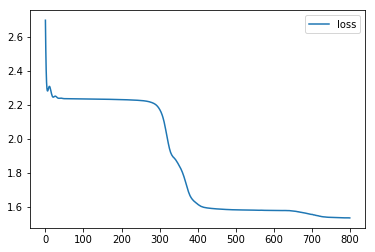

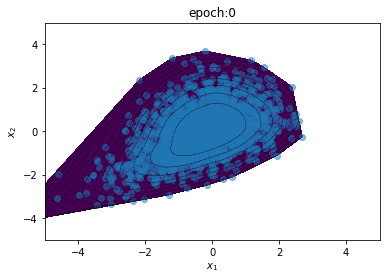

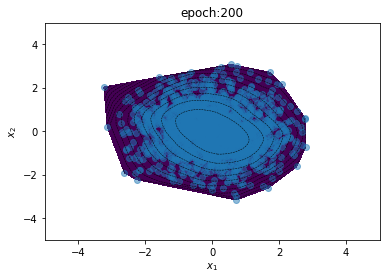

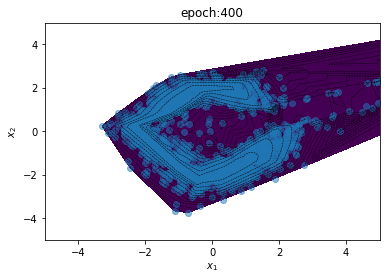

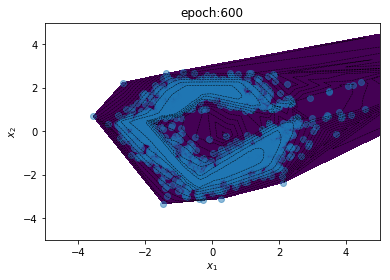

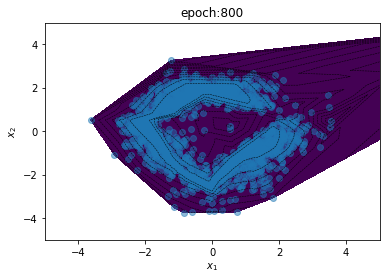

In [45]:
L = [] # L will be a list of losses for plotting.

f = plt.figure() # create a figure and an axis to plot loss curve.
ax = f.add_subplot(1,1,1)

# generate xi yi for mesh grid.
xi, yi= np.meshgrid(*([np.linspace(-5, 5, num_samples)] * 2))

for epoch in range(num_epochs+1):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    logp = model.logp(x_data)
    loss = -logp.mean() # get NLL loss for training.
    
    if epoch%50 == 0:
      print("epoch:",epoch,"loss:",loss.item())
      
    if epoch%200 == 0:
      
      ft = plt.figure() # create a figure and an axis to plot generated sample points.
      axt = ft.add_subplot(1,1,1)
      axt.set_title("epoch:%g"%(epoch))
      
      z = torch.randn(num_samples, num_vars)
      x = model.forward(z)
      logp = model.logp(x) # get log(probability) of each sampled point.
      
      zi = griddata(x.detach().numpy(), logp.detach().numpy(), (xi, yi))
      plt.contour(xi, yi, zi, 15, linewidths=0.5, colors='k')
      plt.contourf(xi, yi, zi, 15,vmax=abs(zi).max(), vmin=-abs(zi).max())
      axt.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), alpha=0.5, label='generated') # generated mesh data and plot contour.
      
      plt.xlim([-5, 5]) # limit x and y axes between [-5,5] for better viewing.
      plt.ylim([-5, 5])

      plt.xlabel('$x_1$') # label axes.
      plt.ylabel('$x_2$')
      
    L.append(loss.detach().numpy()) # at each epoch add new loss to L
    
    optimizer.zero_grad() # do the training of model's parameters.
    loss.backward()
    optimizer.step()
    
ax.plot(range(len(L)),np.array(L),label = 'loss') # plot the loss curve.
ax.legend()

plt.show()

Visualize training result.

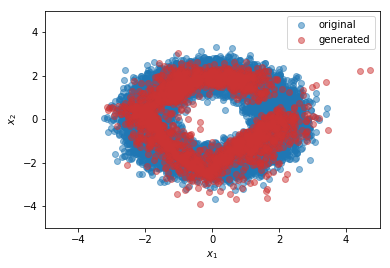

In [46]:
z = torch.randn(num_samples, num_vars) # create a random dataset to perform testing.
x = model.forward(z)

plt.figure() # plot training data along with generated data.
plt.scatter(x_data[:,0], x_data[:,1], alpha=0.5, label='original')
plt.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), alpha=0.5, label='generated',c='#CC3333')
plt.legend()

plt.xlim([-5, 5]) # limit x and y axes between [-5,5] for better viewing.
plt.ylim([-5, 5])

plt.xlabel('$x_1$') # label axes.
plt.ylabel('$x_2$')

plt.show()

# Task
Now we have NICE network, we can also implement RealNVP network with only little changes.

At each layer, RealNVP perform this transformation:

\begin{equation}
\left\{
\begin{array}\\
y_0' = y_0 \exp(s(y_1))+t(y_1) \\
y_1' = y_1
\end{array}
\right.
\end{equation}

### hints:

RealNVP has a $\ln(determinant)$ of this form
\begin{equation}
\ln
\left|
\begin{array}\\
\exp(s(y_1))&0\\
\frac{\partial}{\partial{y_1}}(y_0 \exp(s(y_1))+t(y_1))&1
\end{array}
\right|
= s(y_1)
\end{equation}

To test your implement, you can just copy the training code of NICE network.

In [47]:
class RealNVP(torch.nn.Module):
    '''
    A Pytorch implement of RealNVP Network.
    
    Args:
        num_vars(int): length of inputs.
        num_layers(int): number of RealNVP layers.
        hidden_t(int): number of hidden units of in each t layer.
        hidden_s(int): number of hidden units of in each s layer.
       
    Attributes:
        num_vars(int): length of inputs.
        num_layers(int): number of RealNVP layers.
        translation(nn.ModuleList): list of translation layers.
    '''
    def __init__(self, num_vars, num_layers=2, hidden_s=10, hidden_t=10):
        super(RealNVP, self).__init__()
        self.num_vars = num_vars
        self.num_layers = num_layers

        self.translation = torch.nn.ModuleList()
        self.segmentation = torch.nn.ModuleList()
        for i in range(self.num_layers):
            if i == self.num_layers-1:
                self.segmentation.append(
                    torch.nn.Sequential(
                    torch.nn.Linear(num_vars//2, hidden_s),
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_s, num_vars//2),
                    torch.nn.Tanh()
                    ))
            else:
                self.segmentation.append(
                     torch.nn.Sequential(
                     torch.nn.Linear(num_vars//2, hidden_s),
                     torch.nn.ReLU(),
                     torch.nn.Linear(hidden_s, num_vars//2)
                     ))
            self.translation.append(
                 torch.nn.Sequential(
                 torch.nn.Linear(num_vars//2, hidden_t),
                 torch.nn.ReLU(),
                 torch.nn.Linear(hidden_t, num_vars//2)
                 ))

    def forward(self, z):
        '''
        Generate target distribution from z sampled from gaussian distribution.
        '''
        y0 = z[:,:self.num_vars//2]
        y1 = z[:,self.num_vars//2:]
        self.seg_sum = torch.zeros(z.shape[0], dtype = torch.float32)
        for i in range(self.num_layers):
            if (i%2==0):
                sy = self.segmentation[i](y0)
                self.seg_sum += sy.sum(dim=-1)
                y1 = torch.mul(y1, torch.exp(sy)) + self.translation[i](y0)
            else:
                sy = self.segmentation[i](y1)
                self.seg_sum += sy.sum(dim=-1)
                y0 = torch.mul(y0, torch.exp(sy)) +  self.translation[i](y1)
        return torch.cat((y0, y1), 1)

    def inverse(self, x):
        '''
        Inference gaussian distribution from x sampled from target distribution.
        '''
        y0 = x[:,:self.num_vars//2]
        y1 = x[:,self.num_vars//2:]
        self.seg_sum = torch.zeros(x.shape[0], dtype = torch.float32)
        for i in reversed(range(self.num_layers)):
            if (i%2==1):
                sy = -self.segmentation[i](y1)
                self.seg_sum += sy.sum(dim=-1)
                y0 = torch.mul(torch.exp(sy), y0 - self.translation[i](y1))
            else:
                sy = -self.segmentation[i](y0)
                self.seg_sum += sy.sum(dim=-1)
                y1 = torch.mul(torch.exp(sy), y1 - self.translation[i](y0))
            
        return torch.cat((y0, y1), 1)

    def logp(self, x):
        '''
        Calculate x's log(probability).
        '''
        z = self.inverse(x)
        return (-0.5*(z**2).sum(dim=1) + self.seg_sum)

In [48]:
num_vars = 4 
model = RealNVP(num_vars) 
z = torch.randn(1000,num_vars)

x = model.forward(z) # generate a new dataset.
z_infer = model.inverse(x) # inference back to the original dataset.

from numpy.testing import assert_array_almost_equal
assert_array_almost_equal(z_infer.detach().numpy(),z.detach().numpy()) # test if they are the same.

### Training

In [49]:
torch.manual_seed(42)

num_epochs = 800 # define parameters of NICE network.
num_layers = 4
hidden_t = 10
hidden_s = 10
num_samples = 2000
num_vars = x_data.shape[-1]

model = RealNVP(num_vars, num_layers,hidden_t, hidden_s) # define RealNVP instance and optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

Start training.

epoch: 0 loss: 3.114309549331665
epoch: 50 loss: 1.5587342977523804
epoch: 100 loss: 1.406450629234314
epoch: 150 loss: 1.3781101703643799
epoch: 200 loss: 1.3722264766693115
epoch: 250 loss: 1.346835732460022
epoch: 300 loss: 1.3277391195297241
epoch: 350 loss: 1.329038143157959
epoch: 400 loss: 1.2955329418182373
epoch: 450 loss: 1.285231590270996
epoch: 500 loss: 1.2772300243377686
epoch: 550 loss: 1.2720345258712769
epoch: 600 loss: 1.3034324645996094
epoch: 650 loss: 1.3045966625213623
epoch: 700 loss: 1.267265796661377
epoch: 750 loss: 1.2560040950775146
epoch: 800 loss: 1.2502012252807617


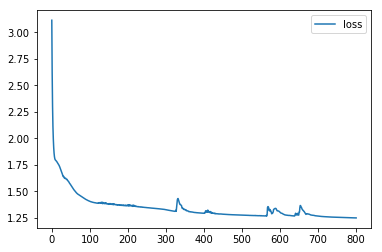

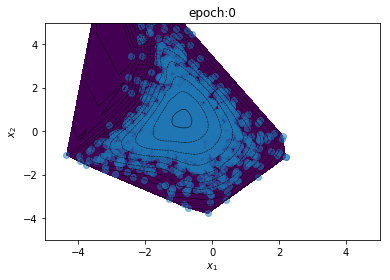

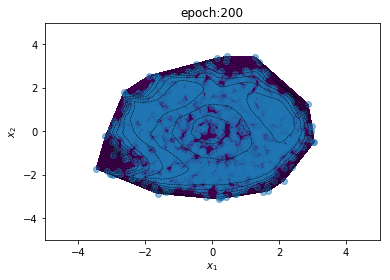

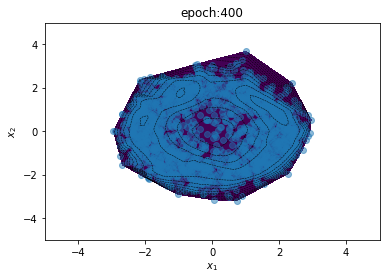

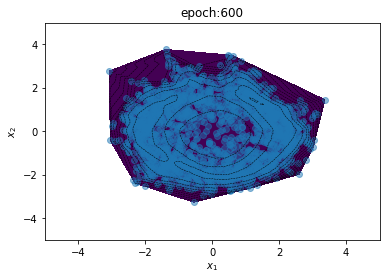

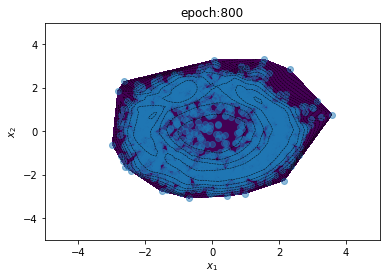

In [50]:
L = [] # L will be a list of losses for plotting.

f = plt.figure() # create a figure and an axis to plot loss curve.
ax = f.add_subplot(1,1,1)

# generate xi yi for mesh grid.
xi, yi= np.meshgrid(*([np.linspace(-5, 5, num_samples)] * 2))

for epoch in range(num_epochs+1):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    logp = model.logp(x_data)
    loss = -logp.mean() # get NLL loss for training.
    
    if epoch%50 == 0:
      print("epoch:",epoch,"loss:",loss.item())
      
    if epoch%200 == 0:
      
      ft = plt.figure() # create a figure and an axis to plot generated sample points.
      axt = ft.add_subplot(1,1,1)
      axt.set_title("epoch:%g"%(epoch))
      
      z = torch.randn(num_samples, num_vars)
      x = model.forward(z)
      logp = model.logp(x) # get log(probability) of each sampled point.
      
      zi = griddata(x.detach().numpy(), logp.detach().numpy(), (xi, yi))
      plt.contour(xi, yi, zi, 15, linewidths=0.5, colors='k')
      plt.contourf(xi, yi, zi, 15,vmax=abs(zi).max(), vmin=-abs(zi).max())
      axt.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), alpha=0.5, label='generated') # generated mesh data and plot contour.
      
      plt.xlim([-5, 5]) # limit x and y axes between [-5,5] for better viewing.
      plt.ylim([-5, 5])

      plt.xlabel('$x_1$') # label axes.
      plt.ylabel('$x_2$')
      
    L.append(loss.detach().numpy()) # at each epoch add new loss to L
    
    optimizer.zero_grad() # do the training of model's parameters.
    loss.backward()
    optimizer.step()
    
ax.plot(range(len(L)),np.array(L),label = 'loss') # plot the loss curve.
ax.legend()

plt.show()

Visualize training result.

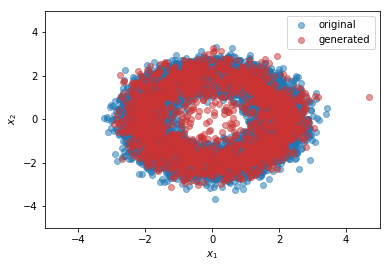

In [52]:
z = torch.randn(num_samples, num_vars) # create a random dataset to perform testing.
x = model.forward(z)

plt.figure() # plot training data along with generated data.
plt.scatter(x_data[:,0], x_data[:,1], alpha=0.5, label='original')
plt.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), alpha=0.5, label='generated',c='#CC3333')
plt.legend()

plt.xlim([-5, 5]) # limit x and y axes between [-5,5] for better viewing.
plt.ylim([-5, 5])

plt.xlabel('$x_1$') # label axes.
plt.ylabel('$x_2$')

plt.show()